# Quiz 2 - Visão Computacional

## Felipe Bartelt de Assis Pessoa - 2016026841
***
# Introdução
O presente trabalho visa estudar calibração de câmeras. Para isso, tomar-se-á como base três métodos diferentes: o primeiro dado por um [toolbox](http://www.vision.caltech.edu/bouguetj/calib_doc/), bastante eficiente e preciso; o segundo é o método Naïve, que consiste em estimar a distância focal da câmera com base na análise direta de coordenadas, em pixels, de um objeto numa foto e suas dimensões reais, partindo do pressuposto que o centro da imagem é o centro geométrico; o terceiro e último é a calibração direta (*direct parameter calibration*), implementado manualmente em Python, com base no livro de Trucco e Verri.

Os resultados obtidos serão comparados de forma a se avaliar a qualidade de cada método.

# Toolbox Calibration
Devido a um erro inesperado com o Octave, optou-se por utilizar o mesmo *toolbox* para o MATLAB. 

Tirou-se 10 fotos em posições diferentes do *pattern* fornecido, movendo-se a câmera ao invés do alvo, uma vez que o resultado é o mesmo. Uma dessas posições é mostrada a seguir, já com as bordas determinadas pelo *toolbox*:
![](./image1.png)

Os resultados do toolbox foram:
![](./image2.png)

$f_x = 1009.01844\pm 8.31440, f_y = 1004.94045\pm  9.05035$

Após a calibração, pôde-se visualizar as diferentes formas do algoritmo interpretar os diferentes ângulos de foto, o que justifica a ação de mover a câmera ao invés do alvo:
![](./image3.png)
![](./image4.png)

# Naïve Calibration
Para a implementação do método naïve, mediu-se um livro com uma trena e obteve-se as dimensões: $\text{altura} = 23.2\;\text{cm}$ e $\text{largura} = 16.1\;\text{cm}$ e tirou-se uma foto a $80\;\text{cm}$ de distância


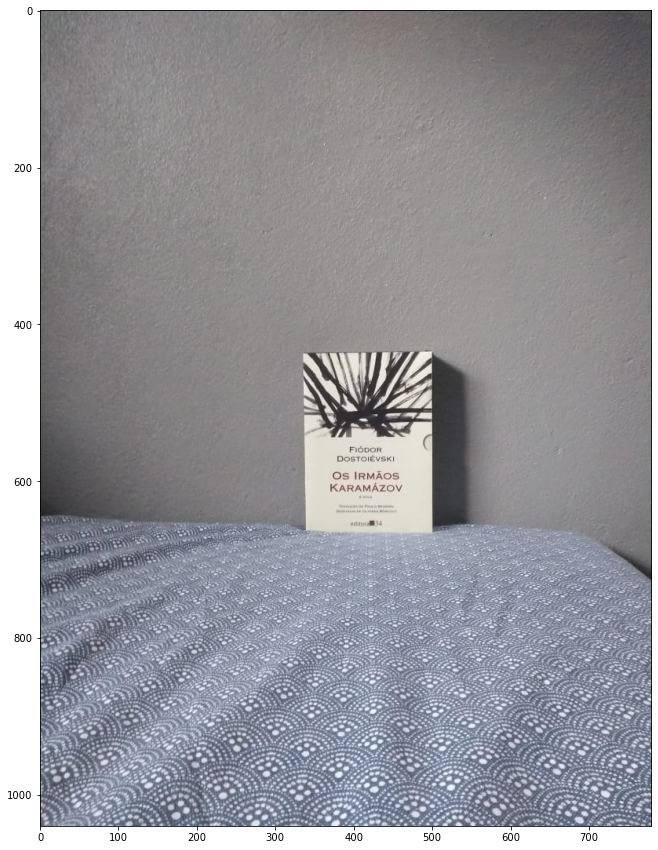

In [163]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

img = cv2.imread('calib2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (15,15))
plt.imshow(img)
plt.show()


Abriu-se a imagem no GIMP de forma a visualizar o número de pixel equivalente para as bordas. O topo e base do livro correspondem, respectivamente a $660\text{px}$ e $437\text{px}$, já as laterais esquerda e direita, $335\text{px}$ e $500\text{px}$, respectivamente. Dessa forma, pode-se determinar o foco da câmera por:
$$
f_x = Z\frac{\Delta x}{X} = Z\frac{500-335}{X}\\
f_y = Z\frac{\Delta y}{Y} = Z\frac{660-437}{Y}
$$
Onde $x,y$ correspondem às coordenadas na imagem e $X,Y$ às dimensões reais do objeto e $Z$ à distância da câmera até o objeto. Dessa forma, assumindo-se que os pontos principais correspondem ao centro geométrico da imagem, obtém-se a matriz de parâmetros intrínsecos $M_{int}$ por meio do seguinte código:

In [164]:
xpx = 500-335 
ypx = 660-437
x = 16.1
y = 23.2
z = 80
fx = xpx/x*z
fy = ypx/y*z
print('fx = ',fx, 'fy = ', fy)
cx, cy = np.shape(img)[1]/2, np.shape(img)[0]/2
print('cx = ', cx, '\t\tcy = ', cy)

M_int = np.diag([fx, fy, 1])
M_int[0:2,2] = [cx,cy]
print('\nM_int:')
print(M_int)

fx =  819.8757763975154 fy =  768.9655172413793
cx =  390.0 		cy =  520.0

M_int:
[[819.8757764    0.         390.        ]
 [  0.         768.96551724 520.        ]
 [  0.           0.           1.        ]]



Pode-se notar que os valores obtidos via método naïve são bastante próximos ao encontrado pelo *toolbox* de calibração.

# Direct Parameter Calibration

Para a implementação desse método, tomou-se como base o algoritmo descrito em (**EMANUELE TRUCCO ; ALESSANDRO VERRI, Introductory techniques for 3-D computer vision, Upper Saddle River, Nj: Prentice Hall, 1998.**). Tirou-se a seguinte foto para a calibração (com eixos adotados desenhados):
![](./calib3_comeixo.png)

O primeiro passo para o algoritmo é mensurar as dimensões reais do tabuleiro, novamente as dimensões do quadrado são $28\times28\text{ cm}$ e a margem sobressalente na junção dos dois alvos corresponde a $21\text{ cm}$, com essas informações, pode-se mapear toda borda para coordenadas nos eixos do mundo.

Para a extração das bordas em pixels, segundo passo do algoritmo, utilizou-se as funções da opencv com base [em uma pergunta do stackoverflow](https://stackoverflow.com/questions/50984205/how-to-find-corners-points-of-a-shape-in-an-image-in-opencv). O trecho de código seguinte realiza essa extração e mostra a imagem com as quinas obtidas coloridas em vermelho:

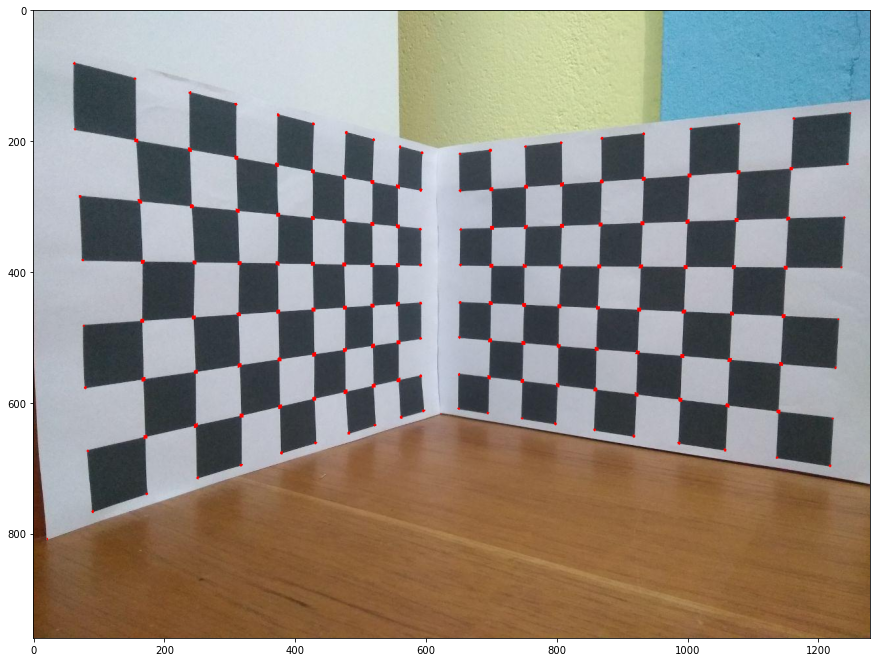

In [130]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('calib3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,5,3,0.04)
ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
dst = np.uint8(dst)
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
img[dst>0.1*dst.max()]=[0,0,255]

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (15,15))
plt.imshow(img)


Com uma análise minuciosa, percebeu-se que todas as quinas foram encontradas, porém houve a adição de 3 quinas indesejadas: uma na quina inferior esquerda do alvo e duas na junção dos alvos, uma na quina inferior e outra no meio da junção, que não é visível na imagem acima. Essas quinas são removidas manualmente.

Ordenou-se o vetor de pontos de imagem `img_points` com base nos valores de eixo $x$ das coordenadas. Essa ordenação não foi totalmente satisfatória, provavelmente por existir uma ondulação no tabuleiro à esquerda, o que implicou em alguns pontos do plano XZ terem ordens trocadas. Essa ordenação foi pior ainda para o plano YZ, que tinha diversos pontos desordenados. Dessa forma, foi necessária uma reordenação. Essa primeira ordenação aparentava percorrer o plano XZ da esquerda para direita e de cima para baixo, enquanto o plano YZ era percorrido da esquerda para direita e de baixo para cima, assim, preferiu-se forçar esse comportamento com as correções. Para garantir essa ordenação no plano XZ, simplesmente trocou-se pontos cuja coordenada em $x$ eram próximas, porém sua coordenada $y$ era menor que o ponto anterior. Para o plano YZ, ordenou-se blocos de 7 pontos por meio das respectivas coordenadas $y$.

Essa reordenação foi conferida e se confirmou correta.

Para o mapeamento de coordenadas da imagem para coordenadas do mundo, utilizou-se o *container* `deque`, contendo as distâncias possíveis por quadrado em $x$ e $z$. Escolheu-se trabalhar com `deque` pela conveniência de como os pontos ficaram ordenados.

Checou-se se o mapeamento havia sido correto, o que se mostrou verdadeiro.

In [87]:
from collections import deque
xy_pos = deque(28*np.arange(9,-1,-1)+21)
z_pos = deque(28*np.arange(7,-1,-1))
z_pos.rotate(1)
xy_pos.append(21)
world_points = []

# Ordenacao dos image points
img_points = np.copy(corners[corners[:, 0].argsort()])
img_points = np.delete(img_points, [0,81,82] , axis=0)

for idx, corner in enumerate(img_points[0:80,:]):
# Reordenacao do plano XZ 
    if idx>0:
        if (corner[1]<img_points[idx-1,1]) and abs(corner[0]-img_points[idx-1,0])<7:
            img_points[[idx-1, idx]] = img_points[[idx, idx-1]]

for idx, corner in enumerate(img_points[80::,:]):
# Reordenacao do plano YZ
    if not idx%8:
        img_points[idx+80:idx+88,:] = img_points[80+idx+img_points[idx+80:idx+88, 1].argsort()[::-1],:]

# Mapeamento img points -> world points
rot = -1
change_plane = 0
for idx, corner in enumerate(img_points):
    z_pos.rotate(rot)

    if idx > 0 and not(idx%8):
        xy_pos.rotate(rot)

    if change_plane:
        world_points.append([0, xy_pos[0], z_pos[0], 1])
    else:
        world_points.append([xy_pos[0], 0, z_pos[0], 1])

    if idx == 79:
        change_plane = 1
        z_pos.rotate(rot)
        xy_pos.rotate(rot)
        rot = 1

world_points = np.array(world_points)


Finalmente, implementou-se a função `direct_parameter_calib`, cujos argumentos são os pontos obtidos nos passos 1 e 2. Essa função executa os demais passos do algoritmo resumido na página 131 do livro supracitado. Essa função tem como retorno: $f_x, f_y, \gamma, \alpha, \mathbf{R}, \mathbf{T}$.

Uma vez que a função `linalg.svd` já retorna as matrizes ordenadas de forma decrescente, encontrar a coluna de $V$ correspondente ao menor valor singular, torna-se apenas pegar a última linha de $V^T$.

O passo 7, "encontrar um ponto provavelmente distante do centro da imagem", foi executado tomando-se o índice do ponto cuja coordenada $x$ era a maior do conjunto de pontos da imagem.

Para o passo 8, utilizou-se a pseudo-inversa de A para o cálculo de mínimos quadrados.

Os passos que não foram citados, não apresentam grandes diferenças do livro texto, uma vez que são diretos e para suas implementações não houve uso de métodos não usuais.

In [151]:
def direct_parameter_calib(img_points, world_points):
    A = np.array([
                  np.array([np.array([x[0]*world_points[idx], -x[1]*world_points[idx]]).flatten()]).flatten() 
                            for idx,x in enumerate(img_points)
                 ])

    # Passo 3
    U,S,V = np.linalg.svd(A, full_matrices = False)
    sol = V[-1,:]

    # Passo 4
    gamma = np.sqrt(sol[0]**2+sol[1]**2+sol[2]**2)
    alfa = np.sqrt(sol[4]**2+sol[5]**2+sol[6]**2)/gamma
    
    # Passo 5
    r2 = np.reshape(sol[0:3]/gamma, (-1,1))
    r1 = np.reshape(sol[4:7]/(alfa*gamma),(-1,1))
    Ty = sol[3]/gamma
    Tx = sol[7]/(alfa*gamma)

    # Passo 6
    r3 = np.reshape(np.cross(r1.T,r2.T), (-1,1))
    
    # Passo 7
    far_point = np.argmax(img_points, axis = 0)[0]
    if img_points[far_point,0] * (r1[0,0] * world_points[far_point,0] + r1[1,0] * world_points[far_point,1]
                                  + r1[2,0] * world_points[far_point,2] + Tx) > 0:
        r2 = -r2
        r1 = -r1
        Ty, Tx = -Ty, -Tx

    # Passo 8
    A = np.reshape([([x[0], float(world_points[idx][0:-1] @ r1) + Tx]) 
                    for idx,x in enumerate(img_points)], (-1,2))
    b = np.reshape([[-x[0]*float(world_points[idx][0:-1] @ r3)] for idx,x in enumerate(img_points)], (-1,1))

    Tz, fx = np.linalg.pinv(A) @ b
    fy = fx/alfa
    R = np.array([r1.ravel(), r2.ravel(), r3.ravel()])
    T = np.array([Tx, Ty, float(Tz)])
    return fx, fy, gamma, alfa, R, T

In [152]:
fx, fy, gamma, alpha, R, T = direct_parameter_calib(img_points, world_points)
print('(fx,fy) = ', (float(fx), float(fy)))
print('alpha = ', alpha)
print('gamma = ', gamma)
print('R = ', R)
print('T = ', T)

(fx,fy) =  (201.88475718898007, 192.2384269429618)
alpha =  1.0501789907429921
gamma =  0.0027699870693444805
R =  [[ 0.85251139 -0.37644335  0.36264959]
 [ 0.40319409  0.14953124  0.90281501]
 [-0.39408615 -0.62344191  0.27925682]]
T =  [-249.33117415 -248.52869371  129.30555748]



Pelos resultados acima, percebe-se uma grande discrepância com relação aos obtidos para as ditâncias focais, tanto com base no toolbox quanto no método Naïve. Tentou-se estipular um motivo para essa discrepância, porém não foram encontrados erros para as coordenadas, tanto no referencial do mundo quando no referencial da imagem, e também não se encontrou erros de implementação do método. Toma-se assim os seguintes resultados como obtidos pelo método de calibração direta:
$$
\begin{align}
(f_x, f_y) &\approx (201.88, 192.24)\\
\alpha &\approx 1.05 \\
\gamma &\approx 0.0028 \\
\mathbf{T} &\approx \begin{bmatrix} -249.33 & -248.53 & 129.31 \end{bmatrix}^T \\
\mathbf{R} & \approx \begin{bmatrix} 0.85 & -0.38 & 0.36 \\
0.40 &  0.15 & 0.90\\
-0.39 & -0.62 & 0.28
\end{bmatrix}
\end{align}
$$

Como forma de análise do comportamento do algoritmo, testou-se como se variavam as ditâncias focais com a variação de números de pontos utilizados. Assim, tomou-se os resultados para os primeiros $8,9,10,\dots,160$ pontos, sendo metade obtido no plano $XZ$ e a outra metade no plano $YZ$. Plotou-se os resultados obtidos para $f_x, f_y$ em função no número de pontos e calculou-se média e variância desses parâmetros:

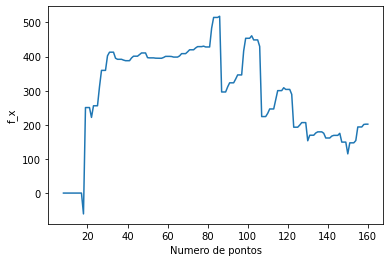

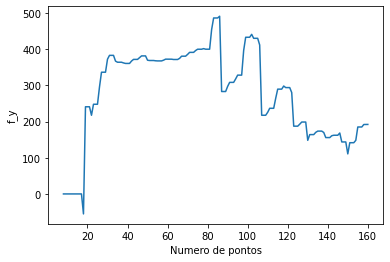

Variancia de fx:  17749.973017555145
Variancia de fy:  15330.230704167352
Media de fx:  295.54623483981834
Media de fy:  279.5250414095975


In [157]:
fx_list, fy_list, alpha_list, gamma_list = [], [], [], []
number_points = np.arange(8,161)

for number in number_points:
    lim_xz = np.arange(0, round(number/2))
    lim_yz = np.arange(80, 80+round(number/2))
    slices = np.append(lim_xz, lim_yz)
    fx, fy, gamma, alpha, R, T = direct_parameter_calib(img_points[slices,:], world_points[slices,:])
    fx_list.append(fx)
    fy_list.append(fy)
    alpha_list.append(alpha)
    gamma_list.append(gamma)

plt.plot(number_points, fx_list)
plt.xlabel('Numero de pontos')
plt.ylabel('f_x')
plt.show()

plt.plot(number_points, fy_list)
plt.xlabel('Numero de pontos')
plt.ylabel('f_y')
plt.show()

print('Media de fx: ', np.mean(fx_list))
print('Media de fy: ', np.mean(fy_list))
print('Variancia de fx: ', np.var(fx_list))
print('Variancia de fy: ', np.var(fy_list))


O comportamento visto acima não era o esperado. Imaginava-se que as distâncias focais aumentassem conforme o número de pontos aumenta, tomando como ideal o valor obtido via toolbox. Percebe-se ainda, que utilizando metade dos pontos totais, o algoritmo converge para distâncias focais próximas de $500$, praticamente metade do obtido pelo toolbox.

De forma condensada, os resultados obtidos para as distâncias focais são:

| Método| $f_x$ | $f_y$ |
| :-: | :-: | :-: |
| Toolbox | 1009.01 | 1004.9 |
| Naïve | 819.88 | 768.97 |
| Direct | 201.88 | 192.24 |

Por não se conseguir especular o motivo da discrepância de resultados da calibração direta, mesmo com a variação do número de pontos, tende-se a concluir que o método implementado pelo toolbox é o melhor dos três testados, o método Naïve é interessante para aplicações onde não é necessário grande precisão, uma vez que o resultado obtido por esse método foi suficientemente próximo do toolbox. A calibração direta, com a implementação adotada, mostrou-se ineficiente, a variância das distâncias focais é muito grande quando se varia o número de pontos e nenhum dos resultados obtidos por esse método chegou tão próximo do toolbox quanto o método Naïve.

Por fim, mostra-se os gráficos de $\alpha, \gamma$ em função da mesma variação de número de pontos. Ambos se estabilizam em seus valores finais a partir de 20 pontos:

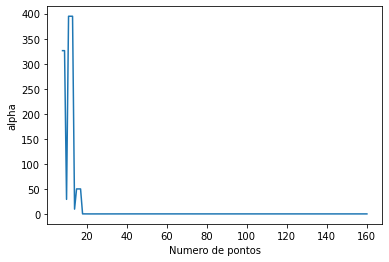

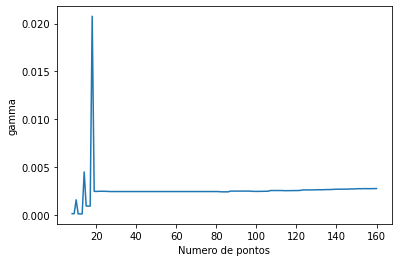

In [160]:
plt.plot(number_points, alpha_list)
plt.xlabel('Numero de pontos')
plt.ylabel('alpha')
plt.show()

plt.plot(number_points, gamma_list)
plt.xlabel('Numero de pontos')
plt.ylabel('gamma')
plt.show()